In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import galois

To implement Simon's algorithm, we will use the `.unitary` method

In [3]:
def simon_function(s: str):
    # Create a QuantumCircuit implementing a query gate for Simon problem obeying the
    # promise for the hidden string `s`

    # The quantum circuit will have 2n qubits for n being the length of s
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will
    # effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function
    # g(x) = min{x,x ^ s}, which is a very simple function that satisfies the promise.
    # (The operation ^ is the bitwise XOR.) Then we take f to be the composition of g
    # and the random permutation pi. This gives us a random function satisfying the
    # promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

Next, we run the Simon problem circuit $k$ times and return the results:

In [12]:
def simon_measurements(problem: QuantumCircuit, k: int):
    # This is the quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    # implements f, gets k measurement outcomes to be post-processed later.

    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    
    qc.measure(range(n), range(n))

    display(qc.draw("mpl"))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

In [9]:
input = "101001"

Next, we follow up with our classical postprocessing step to compute the nullspace

In [13]:
def simon_algorithm(problem: QuantumCircuit, r = 10):
    # Given a `QuantumCircuit` that implements a query gate for Simon problem, return
    # the hidden string `s`.

    # Quantum part: run the circuit defined previously k times and gather the measurement
    # results. Replace +10 by +r for any nonnegative integer r depending on desired
    # confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + r)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Convert back to a string
    print("Guess for hidden string s: ")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

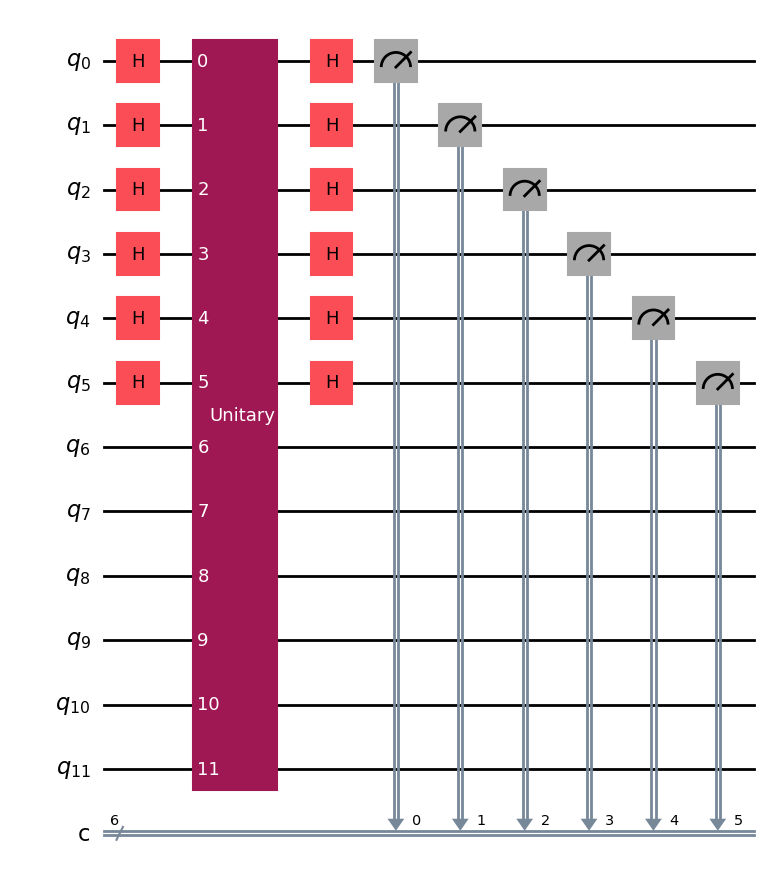

Guess for hidden string s: 


'101001'

In [14]:
display(simon_algorithm(simon_function(input)))